# Poprawa współczynników filtru 
---
<p align="center">
    <img src="./doc/img/FIR.png", width = "500px">
</p>

## Sekcja konfiguracyjna 

In [19]:
# Parametry filtru
filter = {
    'N_fft':   512,     # FFT N próbek -> 2^m
    'm_order': 51,      # Długość filtru
    'fs':      48e3,    # Częstotliwość próbkowania
    'f_pass':  9.6e3,   # Częstotliwość graniczna pasma zaporowego
    'tr_band': 2.2e3,   # Szerokość pasma przejściowego
    'd1_db':   2,       # df1 [db] maksymalne pulsacje w paśmie przepustowym
    'd2_db':   -80,     # df2 [db] minimalna wartość tłumienia w paśmie zaporowym
}

## Wyznaczanie parametrów filtru - metoda okna

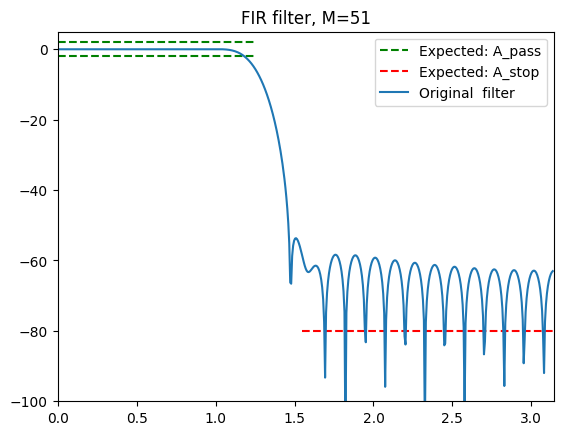

Initial value cost function: 4.191753283269686 


In [20]:
from filter import filter_utils
from scipy import signal
import numpy as np

# Normalizacja filtru f->2pi
filter_n = filter_utils.normalize_filter (filter)

# Współczynniki filtru metoda okienkowa
coef     = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window='hamming')
f, f_res = signal.freqz(coef, worN=filter['N_fft'])

# Wyświetlenie parametrów filtru
filter_utils.display_LP_filter(f[np.newaxis,:], f_res[np.newaxis,:], filter_n)

# Domyślna wartość funkcji kosztu
cost_val = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
print("Initial value cost function: {} ".format(cost_val))

## Poprawa współczynników filtru - metoda bazująca na sąsiedztwie
---

In [12]:
from filter import filter_utils
from filter import rvns_filter
import time 

# Parametry zagnieżdżonego algorytmu RVNS
rvnsc_param = {
    'k_prime': 1000,    # Ilość iteracji I stopnia
    'k_bis':   500,     # Ilość iteracji II stopnia
}

# Poprawa filtru algorytmem RVNS
st = time.time()
_, coef_neighbor = rvns_filter.rvns_con(coef, filter_n, rvnsc_param['k_prime'], rvnsc_param['k_bis'])
time_neighbor = time.time() - st 

### Uzyskane rezultaty 

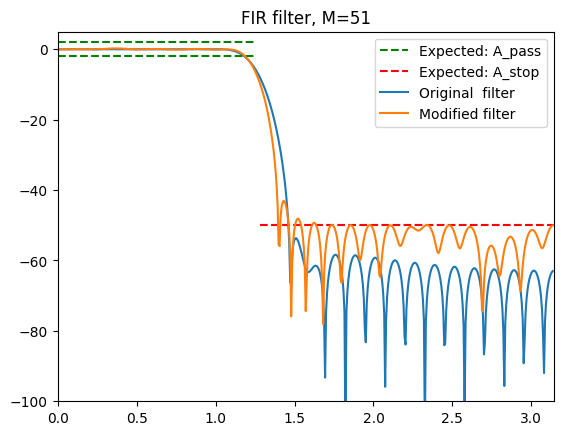

Czas wykonania: 69.530

Wartość funkcji kosztu (metoda okna): 38.8707 
Wartość funkcji kosztu (metoda sąsiedztwo): 23.4421 

Pasmo przejściowe (metoda okna): 1603.12 Hz
Pasmo przejściowe (metoda sąsiedztwo): 1087.50 Hz


In [13]:
# Wyświetlenie uzyskanych rezultatów
f_neighbor, f_res_neighbor = signal.freqz(coef_neighbor, worN=filter_n['N_fft'])
filter_utils.display_LP_filter(np.append(f[np.newaxis,:],     f_neighbor[np.newaxis,:],     axis=0), 
                               np.append(f_res[np.newaxis,:], f_res_neighbor[np.newaxis,:], axis=0 ), filter_n)

cost_val_init = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
cost_val_neighbor = filter_utils.cost_LP_filter(abs(f_res_neighbor), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
f_arg   = np.argmin(np.abs(f_res)>filter_utils.db_to_linear(filter_n['d2_db']))
f_b_arg = np.argmin(np.abs(f_res_neighbor)>filter_utils.db_to_linear(filter_n['d2_db']))
f_pass_i = f[f_arg]*filter['fs']/(2*np.pi)
f_pass_b = f_neighbor[f_b_arg]*filter['fs']/(2*np.pi)
print("Czas wykonania: {:.3f}".format(time_neighbor))
print()
print("Wartość funkcji kosztu (metoda okna): {:.4f} ".format(cost_val_init))
print("Wartość funkcji kosztu (metoda sąsiedztwo): {:.4f} ".format(cost_val_neighbor))
print()
print("Pasmo przejściowe (metoda okna): {:.2f} Hz".format(f_pass_i - filter['f_pass']))
print("Pasmo przejściowe (metoda sąsiedztwo): {:.2f} Hz".format(f_pass_b - filter['f_pass']))

## Poprawa współczynników filtru - algorytm genetyczny (hybryda) 
--- 

Kroki algorytmu:
1. Wyznaczenie puli osobników początkowych (wykorzystanie metody okien)
2. Wyznaczenie permutacji z puli rodziców do krzyżowania 
3. Wyznaczenie losowej sekcji krzyżowania genów pomiędzy osobnikami
4. Wprowadzenie mutacji w wyznaczonych osobnikach z wykorzystaniem RVNS
5. Selekcja najlepszych osobników na podstawie funkcji kosztu
6. Warunek stopu osiągnięty?
    - False -> Powrót krok 2
    - True -> Zwróć najlepszego osobnika

In [23]:
from filter import hybrid_filter

st = time.time()
_, gen_best_solution = hybrid_filter.hybrid_gen_rvns(filter, 100)
time_gen = time.time() - st 

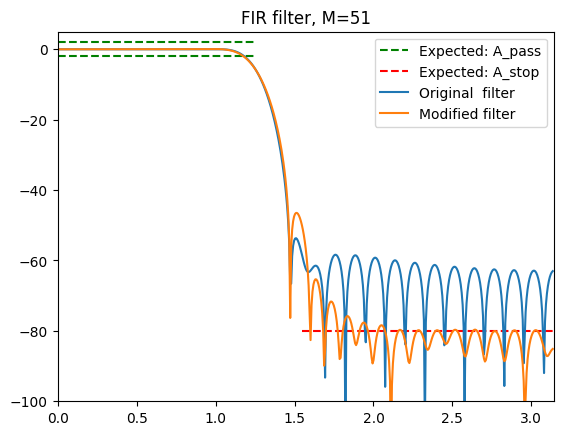

Czas wykonania: 96.742

Wartość funkcji kosztu (metoda okna): 4.1918 
Wartość funkcji kosztu (metoda sąsiedztwo): 3.4359 

Pasmo przejściowe (metoda okna): 3337.50 Hz
Pasmo przejściowe (metoda sąsiedztwo): 2634.38 Hz


In [22]:
gen_best_val = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, 
                                           filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])

f_gen, f_res_gen = signal.freqz(gen_best_solution, worN=filter_n['N_fft'])

filter_utils.display_LP_filter(np.append(f[np.newaxis,:],     f_gen[np.newaxis,:],     axis=0), 
                               np.append(f_res[np.newaxis,:], f_res_gen[np.newaxis,:], axis=0 ), filter_n)

cost_val_i = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
cost_val_b = filter_utils.cost_LP_filter(abs(f_res_gen), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
f_arg   = np.argmin(np.abs(f_res)>filter_utils.db_to_linear(filter_n['d2_db']))
f_b_arg = np.argmin(np.abs(f_res_gen)>filter_utils.db_to_linear(filter_n['d2_db']))
f_pass_i = f[f_arg]*filter['fs']/(2*np.pi)
f_pass_b = f_gen[f_b_arg]*filter['fs']/(2*np.pi)
print("Czas wykonania: {:.3f}".format(time_gen))
print()
print("Wartość funkcji kosztu (metoda okna): {:.4f} ".format(cost_val_i))
print("Wartość funkcji kosztu (metoda sąsiedztwo): {:.4f} ".format(cost_val_b))
print()
print("Pasmo przejściowe (metoda okna): {:.2f} Hz".format(f_pass_i - filter['f_pass']))
print("Pasmo przejściowe (metoda sąsiedztwo): {:.2f} Hz".format(f_pass_b - filter['f_pass']))